In [2]:
!git reset --soft HEAD~

fatal: Cannot do a soft reset in the middle of a merge.


In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg19 import VGG19
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
#import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math

Using TensorFlow backend.


In [2]:
rotated = True
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8954955259382893513, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16029502669
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10605684123239497762
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [3]:
with open('data-localize-rotated0.pckl','rb') as file:
    train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes,test_bbox_sizes,test_bboxes_rot = pickle.load(file)

In [4]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [5]:
def get_model(rotated):
    cnn_base = VGG19(input_shape=(224,224,3),include_top=True,weights='imagenet')

    for layer in cnn_base.layers:
        if layer.name=='block5_conv3':
            break
        layer.trainable = False

    x = cnn_base.get_layer('block5_pool').output
    x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = BatchNormalization()(x)
    #x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = BatchNormalization()(x)
    if rotated==True:
        x = Conv2D(5, kernel_size=(1, 1), padding="same")(x)
        x = Reshape((5,),name='localization_output')(x)
    else: 
        x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
        x = Reshape((4,),name='localization_output')(x)

    y = cnn_base.get_layer('fc2').output
    y = BatchNormalization()(y)
    y = Dense(2048,activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

    losses = {
        "localization_output": "mean_squared_error",
        "classification_output": "categorical_crossentropy",
    }
    lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

    model = Model(inputs=cnn_base.input, outputs=[x,y])
    if rotated==True:
        model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy']})
        #model.save_weights('vgg19-localization-weights-rotated1.h5')
    else:
        model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy',iou_metric]})
        #model.save_weights('abc.hd5')
    return model

In [6]:
#cnn_base.summary()

In [8]:
def convert_bboxes(bboxes):
    features = []
    for b in bboxes:
        height = math.sqrt((b[0]-b[2])**2 + (b[1]-b[3])**2)
        width = math.sqrt((b[2]-b[4])**2 + (b[3]-b[5])**2)
        
        cx = (b[0] + b[4])/2.0
        cy = (b[1] + b[5])/2.0
        
        
        angle = math.atan2((b[2]-b[0]),(b[3]-b[1]))
        features.append([height,width,cx,cy,angle])
    return np.array(features)

In [9]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [10]:
for i in range(5):
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-localize-rotated'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes,test_bbox_sizes,_ = pickle.load(file)
    mod = get_model(rotated)
#     try:
#         model.load_weights('vgg19-localization-rotated'+str(i)+'.hd5')
#     except:
#         model.load_weights('vgg19-localization-weights-rotated.h5')
    print("loaded")
    training_bboxes = convert_bboxes(train_bboxes)
    testing_bboxes = convert_bboxes(test_bboxes)
    history = mod.fit(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": training_bboxes},batch_size=5,epochs=30,
                       validation_data=(np.array(test_images),{"classification_output": test_labels, "localization_output": testing_bboxes}))
    history_record.append(history)
    train_score = mod.evaluate(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": training_bboxes},batch_size=50)
    test_score = mod.evaluate(x=np.array(test_images),y={"classification_output": test_labels, "localization_output": testing_bboxes},batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)

    print("predicting")
    print("Test Score",test_score)
    train_predictions = mod.predict(x=np.array(train_images),batch_size=50)
    test_predictions = mod.predict(x=np.array(test_images),batch_size=50)

    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    #model.load_weights()
    #if rotated:
    #    model.save_weights('vgg19-localization-rotated'+str(i)+'.hd5')
    #else:
    #   model.save_weights('vgg19-localization'+str(i)+'.hd5')

Loading file
loaded
Train on 7755 samples, validate on 647 samples
Epoch 1/30
7755/7755 [==============================] - 237s 31ms/step - loss: 1927.9999 - localization_output_loss: 1926.1008 - classification_output_loss: 1.8992 - localization_output_acc: 0.6075 - classification_output_acc: 0.3323 - val_loss: 547.1755 - val_localization_output_loss: 545.7871 - val_classification_output_loss: 1.3885 - val_localization_output_acc: 0.7326 - val_classification_output_acc: 0.4869
Epoch 2/30
7755/7755 [==============================] - 223s 29ms/step - loss: 705.7373 - localization_output_loss: 704.0750 - classification_output_loss: 1.6623 - localization_output_acc: 0.6645 - classification_output_acc: 0.4226 - val_loss: 415.1806 - val_localization_output_loss: 413.7978 - val_classification_output_loss: 1.3829 - val_localization_output_acc: 0.7342 - val_classification_output_acc: 0.4575
Epoch 3/30
7755/7755 [==============================] - 223s 29ms/step - loss: 640.9962 - localization_ou

Epoch 21/30
7755/7755 [==============================] - 222s 29ms/step - loss: 342.5004 - localization_output_loss: 342.2566 - classification_output_loss: 0.2438 - localization_output_acc: 0.7906 - classification_output_acc: 0.9193 - val_loss: 357.9314 - val_localization_output_loss: 356.7572 - val_classification_output_loss: 1.1742 - val_localization_output_acc: 0.7883 - val_classification_output_acc: 0.6785
Epoch 22/30
1180/7755 [===>..........................] - ETA: 3:04 - loss: 329.6967 - localization_output_loss: 329.4611 - classification_output_loss: 0.2355 - localization_output_acc: 0.7932 - classification_output_acc: 0.9212

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7755/7755 [==============================] - 222s 29ms/step - loss: 326.0907 - localization_output_loss: 325.8432 - classification_output_loss: 0.2475 - localization_output_acc: 0.7896 - classification_output_acc: 0.9162 - val_loss: 375.7151 - val_localization_output_loss: 374.5091 - val_classification_output_loss: 1.2060 - val_localization_output_acc: 0.7805 - val_classification_output_acc: 0.7465
Epoch 23/30
7755/7755 [==============================] - 222s 29ms/step - loss: 338.3626 - localization_output_loss: 338.0939 - classification_output_loss: 0.2687 - localization_output_acc: 0.7894 - classification_output_acc: 0.9137 - val_loss: 355.6336 - val_localization_output_loss: 354.3869 - val_classification_output_loss: 1.2466 - val_localization_output_acc: 0.8053 - val_classification_output_acc: 0.7264
Epoch 24/30
7755/7755 [==============================] - 223s 29ms/step - loss: 322.6668 - localization_output_loss: 322.4247 - classification_output_loss: 0.2421 - localization_output

647/647 [==============================] - 3s 5ms/step
predicting
Test Score [342.43775880981633, 341.08185319148777, 1.355904962493242, 0.7820711027157178, 0.729520873640199]
Loading file
loaded
Train on 7758 samples, validate on 646 samples
Epoch 1/30
7758/7758 [==============================] - 232s 30ms/step - loss: 1919.5986 - localization_output_loss: 1917.6708 - classification_output_loss: 1.9278 - localization_output_acc: 0.6141 - classification_output_acc: 0.3309 - val_loss: 496.0654 - val_localization_output_loss: 493.7517 - val_classification_output_loss: 2.3138 - val_localization_output_acc: 0.7446 - val_classification_output_acc: 0.4087
Epoch 2/30
7758/7758 [==============================] - 218s 28ms/step - loss: 678.1318 - localization_output_loss: 676.4563 - classification_output_loss: 1.6754 - localization_output_acc: 0.6579 - classification_output_acc: 0.4129 - val_loss: 563.4805 - val_localization_output_loss: 561.9355 - val_classification_output_loss: 1.5450 - val_l

7758/7758 [==============================] - 209s 27ms/step - loss: 389.0851 - localization_output_loss: 388.3341 - classification_output_loss: 0.7511 - localization_output_acc: 0.7729 - classification_output_acc: 0.7474 - val_loss: 373.0403 - val_localization_output_loss: 372.2438 - val_classification_output_loss: 0.7965 - val_localization_output_acc: 0.7724 - val_classification_output_acc: 0.7415
Epoch 10/30
7758/7758 [==============================] - 209s 27ms/step - loss: 383.8174 - localization_output_loss: 383.1256 - classification_output_loss: 0.6917 - localization_output_acc: 0.7686 - classification_output_acc: 0.7664 - val_loss: 348.6733 - val_localization_output_loss: 347.8679 - val_classification_output_loss: 0.8054 - val_localization_output_acc: 0.7663 - val_classification_output_acc: 0.7415
Epoch 11/30
7758/7758 [==============================] - 210s 27ms/step - loss: 373.8520 - localization_output_loss: 373.2189 - classification_output_loss: 0.6331 - localization_output

Epoch 29/30
7758/7758 [==============================] - 210s 27ms/step - loss: 314.9693 - localization_output_loss: 314.8132 - classification_output_loss: 0.1560 - localization_output_acc: 0.7911 - classification_output_acc: 0.9510 - val_loss: 340.9480 - val_localization_output_loss: 339.5999 - val_classification_output_loss: 1.3481 - val_localization_output_acc: 0.7771 - val_classification_output_acc: 0.6811
Epoch 30/30
646/646 [==============================] - 3s 5ms/step
predicting
Test Score [340.5879996568426, 339.44312638321156, 1.1448767500765182, 0.7863777082401902, 0.7213622398051684]
Loading file
loaded
Train on 7758 samples, validate on 646 samples
Epoch 1/30
7758/7758 [==============================] - 234s 30ms/step - loss: 1867.2110 - localization_output_loss: 1865.3329 - classification_output_loss: 1.8781 - localization_output_acc: 0.6081 - classification_output_acc: 0.3391 - val_loss: 656.6926 - val_localization_output_loss: 654.2780 - val_classification_output_loss: 

In [14]:
historys = []
for hist in history_record:
    historys.append(hist.history)

In [15]:
if rotated:
    with open('vgg19-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('vgg19-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [13]:
with open('vgg19-predictions-rotated.pckl','rb') as vgg19:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg19)    

In [7]:
test_scores

[[460.9983764837109,
  459.6038505636743,
  1.3945272336418884,
  0.7635239567233385,
  0.6986089751377724],
 [445.03888463015903,
  443.7327626153159,
  1.306120071381653,
  0.7573415670181168,
  0.7017001669042078],
 [634.2890661847849,
  632.587489455846,
  1.7015780339669149,
  0.7476780178377134,
  0.6811145538516089],
 [416.5126430641387,
  415.37218142293926,
  1.1404619724388831,
  0.739938076804666,
  0.6873065159416789],
 [546.8317494111902,
  545.6536472190644,
  1.1781052961807132,
  0.7523219832694936,
  0.766253858527901]]

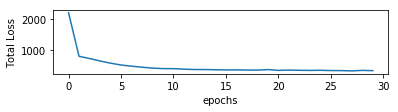

KeyError: 'localization_output_iou_metric'

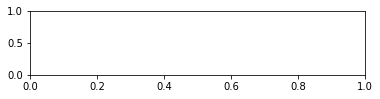

In [17]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [19]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

NameError: name 'model' is not defined

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

NameError: name 'labels_test' is not defined

In [1]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def convert_bboxes(bboxes):
    features = []
    for b in bboxes:
        height = math.sqrt((b[0]-b[2])**2 + (b[1]-b[3])**2)
        width = math.sqrt((b[2]-b[4])**2 + (b[3]-b[5])**2)
        
        cx = (b[0] + b[4])/2.0
        cy = (b[1] + b[5])/2.0
        
        angle = math.atan2((b[0]-b[2]),(b[1]-b[3]))
        features.append([height,width,cx,cy,angle])
    return np.array(features)
testing_bboxes = convert_bboxes(test_bboxes)

In [ ]:
idx = i
i = i + 1
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [ ]:
idx = 109
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [ ]:
idx = 109
img = test_images[idx]
[[h,w,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],0))
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [207]:
math.atan2((test_bboxes[idx][0]-test_bboxes[idx][2]),(test_bboxes[idx][1]-test_bboxes[idx][3]))

-2.815973893380813

In [206]:
print(test_bboxes[idx][0],test_bboxes[idx][1],test_bboxes[idx][2],test_bboxes[idx][3])

180.1451084815663 60.83187288824451 191.50496674706105 94.4770636806505
